In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
df = pd.read_csv('CO2 Emissions_Canada.csv')

print(df.shape)
df.head()

(7385, 12)


,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


# Data Analysis

## Missing Values

In [3]:
df.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

## Numerical Features

In [4]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
df[num_features].head()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,2.0,4,9.9,6.7,8.5,33,196
1,2.4,4,11.2,7.7,9.6,29,221
2,1.5,4,6.0,5.8,5.9,48,136
3,3.5,6,12.7,9.1,11.1,25,255
4,3.5,6,12.1,8.7,10.6,27,244


### Discrete features

In [5]:
discrete_features = [feature for feature in num_features if len(df[feature].unique()) < 25]
print(discrete_features)

['Cylinders']


Cylinders
3     0.012864
4     0.436019
5     0.003521
6     0.331212
8     0.189844
10    0.005687
12    0.020447
16    0.000406
Name: CO2 Emissions(g/km), dtype: float64
Cylinders
4     3220
6     2446
8     1402
12     151
3       95
10      42
5       26
16       3
Name: count, dtype: int64


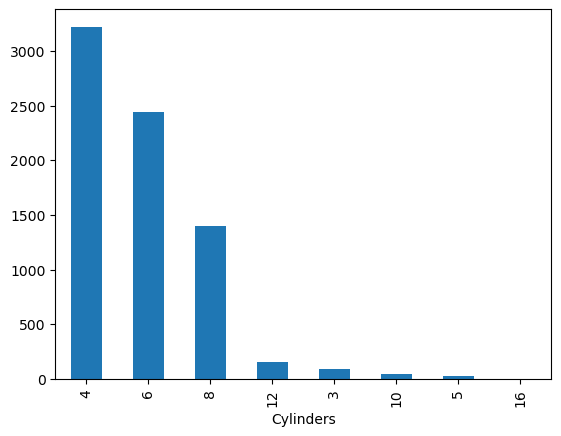

In [6]:
for feature in discrete_features:
    data = df.copy()
    
    #Fraction of total cars for each cylinder type
    print(data.groupby(feature)['CO2 Emissions(g/km)'].count() / len(data))
    
    #Counts of each cylinder type
    print(data[feature].value_counts()) 
    
    data[feature].value_counts().plot.bar()
    plt.show()

Cylinders
3     0.008978
4     0.356458
5     0.003311
6     0.348213
8     0.242903
10    0.008200
12    0.031091
16    0.000846
Name: CO2 Emissions(g/km), dtype: float64


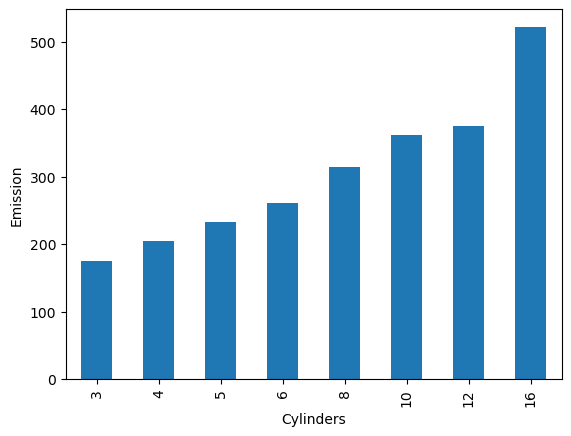

In [7]:
for feature in discrete_features:
    data = df.copy()
    
    #Contribution of each cylinder type to CO2 Emission
    print(data.groupby(feature)['CO2 Emissions(g/km)'].sum() / data['CO2 Emissions(g/km)'].sum())
    data.groupby(feature)['CO2 Emissions(g/km)'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Emission')
    plt.show()

##### Observation:
1. Majority of the cars have 4 cylinders(43%), followed by 6 cylinders(33%) and 8 cylinders(18%)
2. These cars account for 94.7% of total CO2 Emissions
3. Emission increases as number of cylinders increase

### Continuous Features

In [8]:
continuous_features = [feature for feature in num_features if feature not in discrete_features]
print(continuous_features)

['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)']


#### Distribution

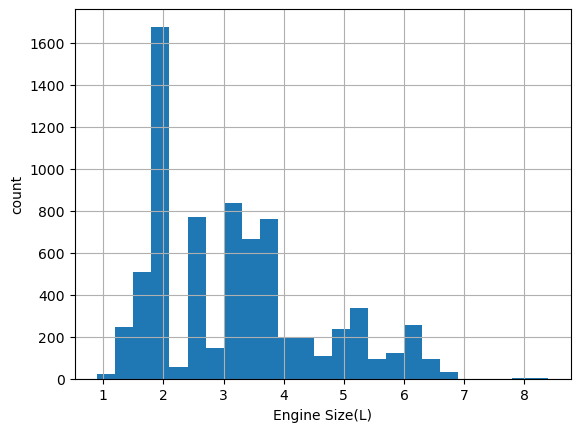

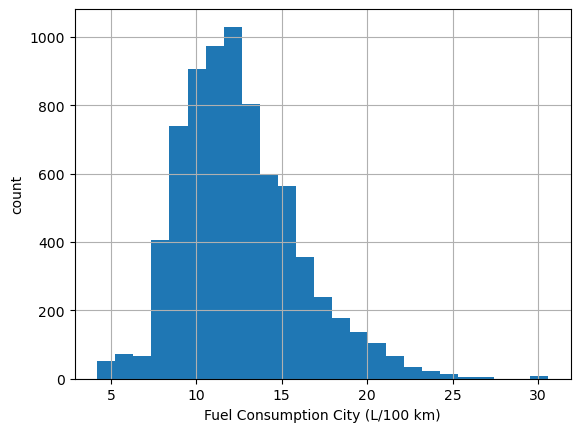

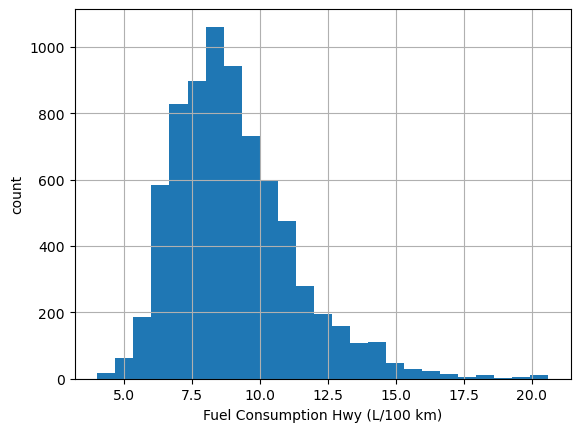

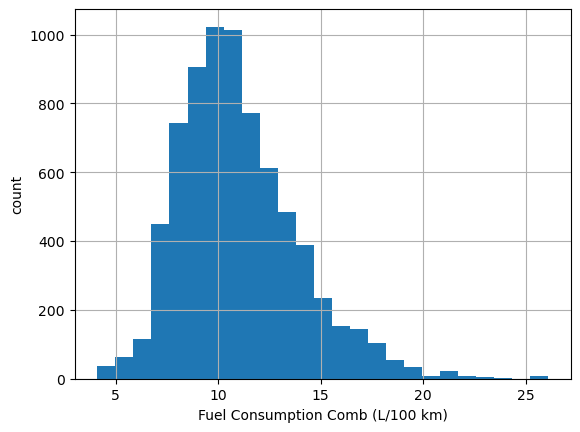

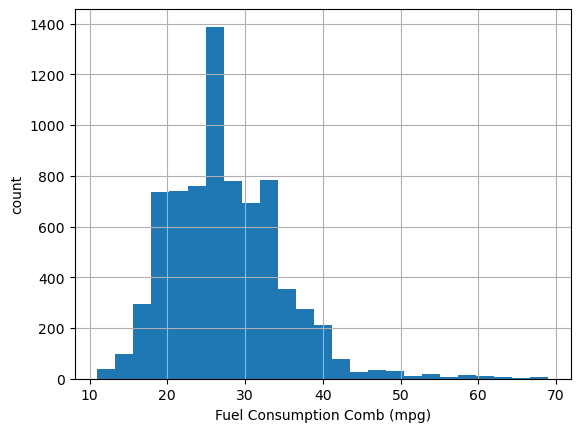

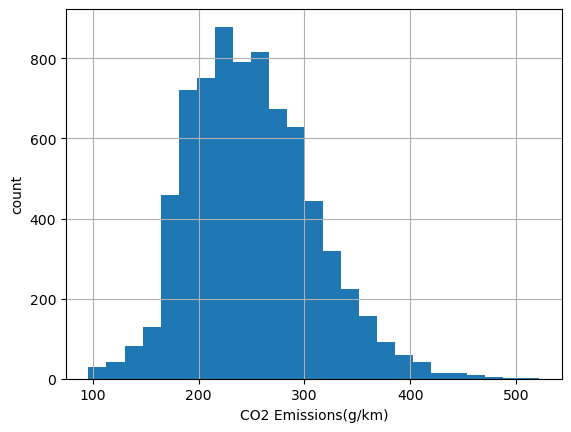

In [9]:
for feature in continuous_features:
    data = df.copy()
    
    data[feature].hist(bins = 25)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

Features are slightly right skewed. Log transformation could be applied

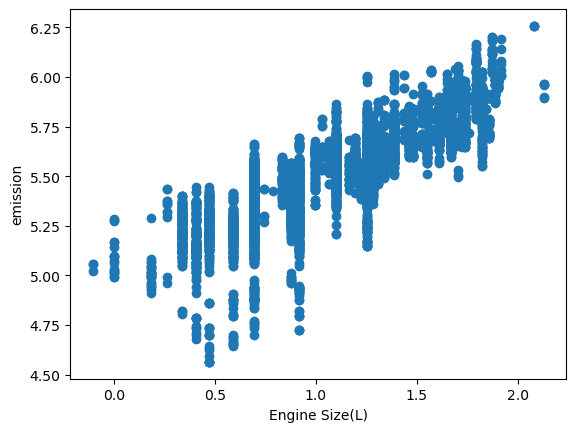

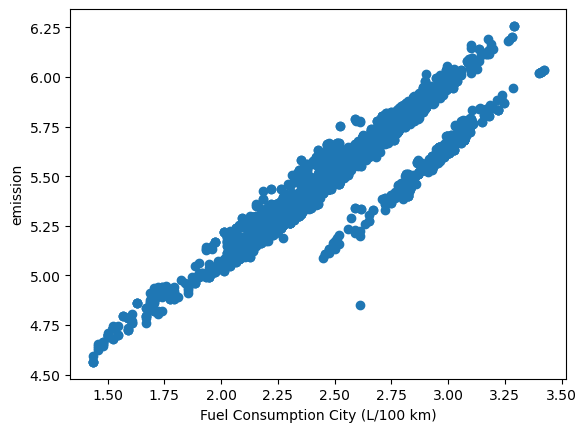

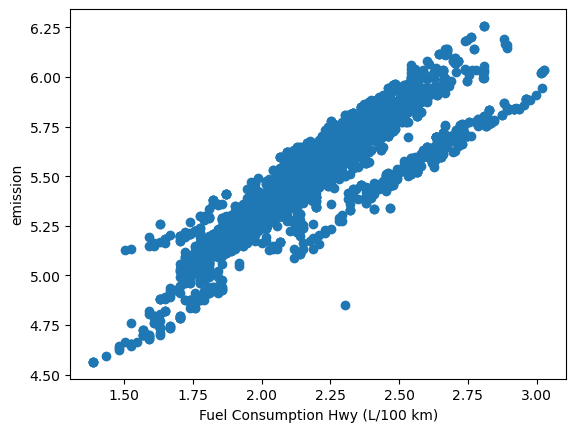

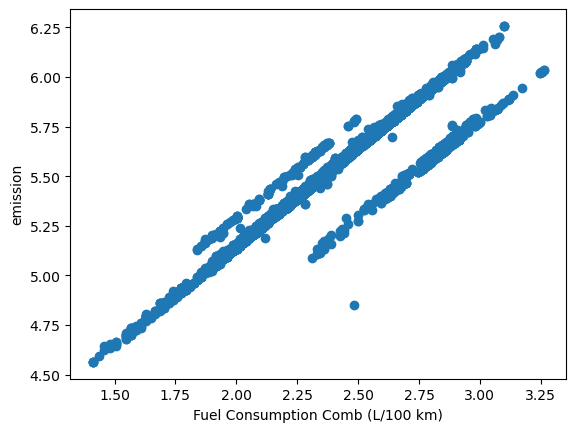

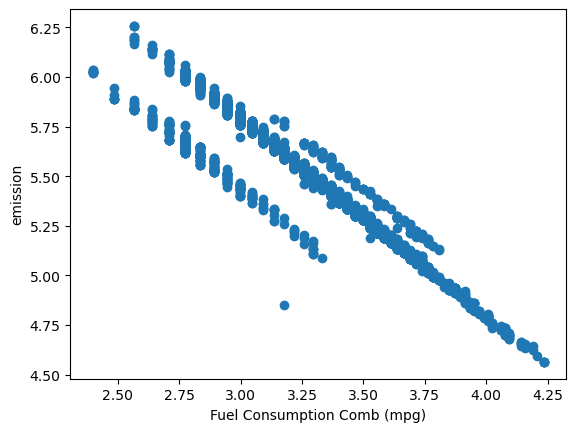

In [10]:
## Log transformation and relationship with target variable

for feature in continuous_features:
    if feature != 'CO2 Emissions(g/km)':
        data = df.copy()
        
        data[feature] = np.log(data[feature])
        
        plt.scatter(data[feature], np.log(data['CO2 Emissions(g/km)']))
        plt.xlabel(feature)
        plt.ylabel('emission')
        plt.show()

##### Observation:
1. Emission increases with increase in engine size
2. Emission increases with increase in Fuel Consumption (City, Hwy, Comb (L/100km))
3. Emission decreases with increase in Fuel Consumption Comb (mpg)

### Continuous Outliers

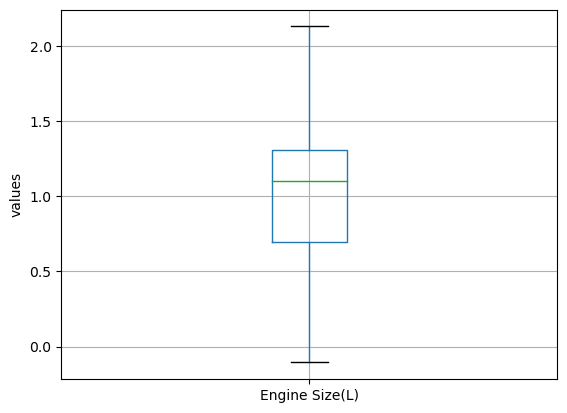

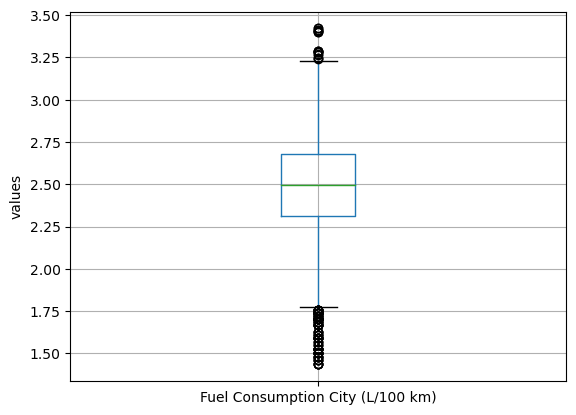

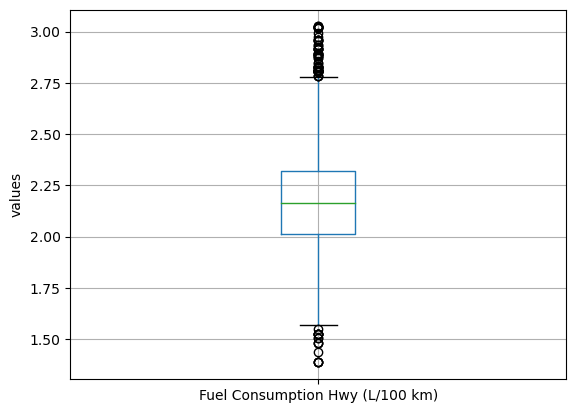

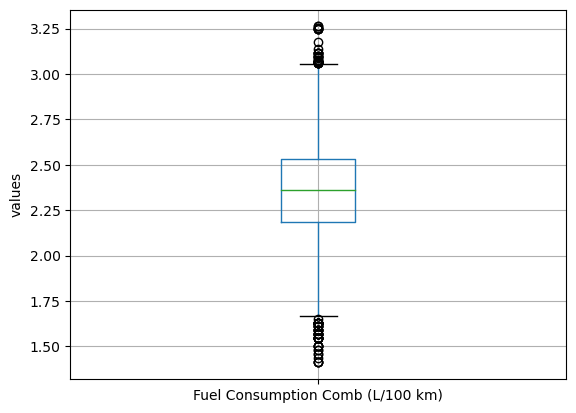

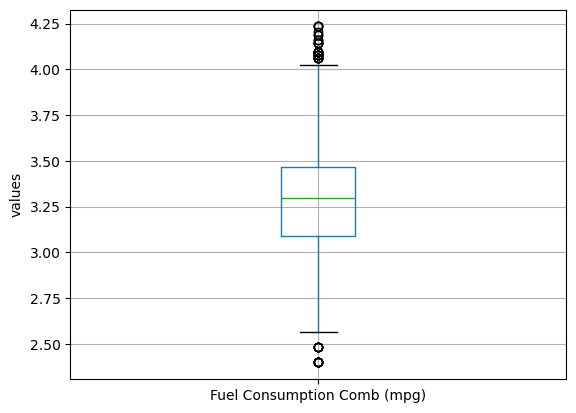

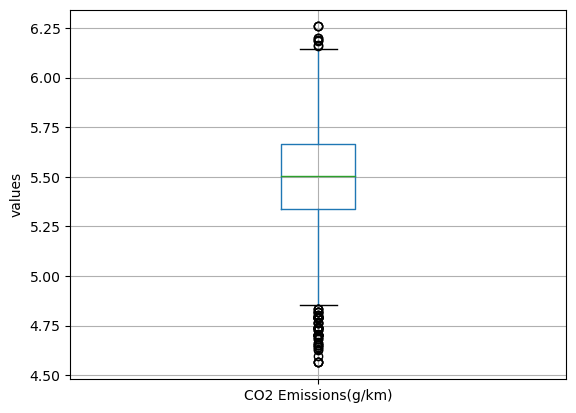

In [11]:
for feature in continuous_features:
    data = df.copy()
    
    data[feature] = np.log(data[feature])
    data.boxplot(column = feature)
    plt.ylabel('values')
    plt.show()

## Categorical Features

In [12]:
cat_features = [feature for feature in df.columns if feature not in num_features]
df[cat_features].head()

,Make,Model,Vehicle Class,Transmission,Fuel Type
0,ACURA,ILX,COMPACT,AS5,Z
1,ACURA,ILX,COMPACT,M6,Z
2,ACURA,ILX HYBRID,COMPACT,AV7,Z
3,ACURA,MDX 4WD,SUV - SMALL,AS6,Z
4,ACURA,RDX AWD,SUV - SMALL,AS6,Z


In [13]:
for feature in cat_features:
    print('{}: {} categories'.format(feature, len(df[feature].unique())))

Make: 42 categories
Model: 2053 categories
Vehicle Class: 16 categories
Transmission: 27 categories
Fuel Type: 5 categories


We can drop 'model' feature as 'make' will provide an overview on the specifications 

In [14]:
cat_features.remove('Model')

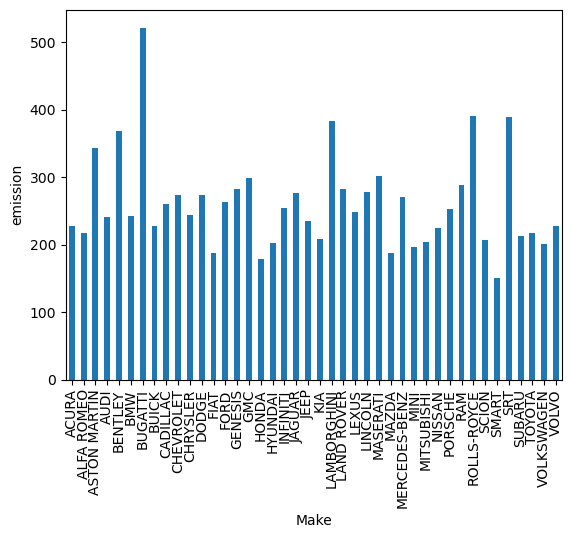

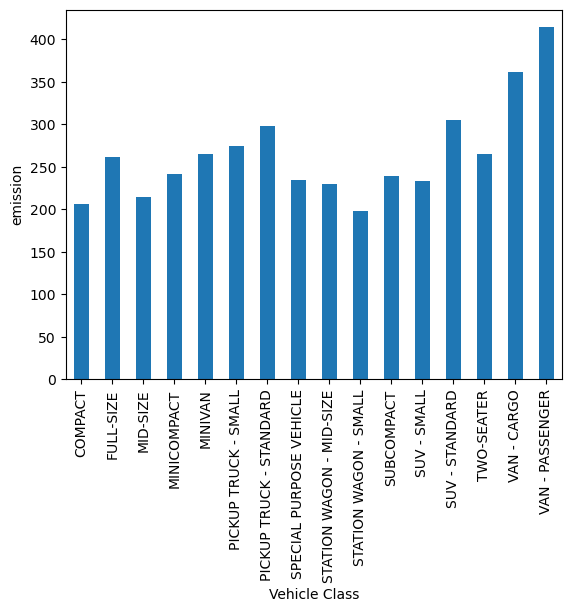

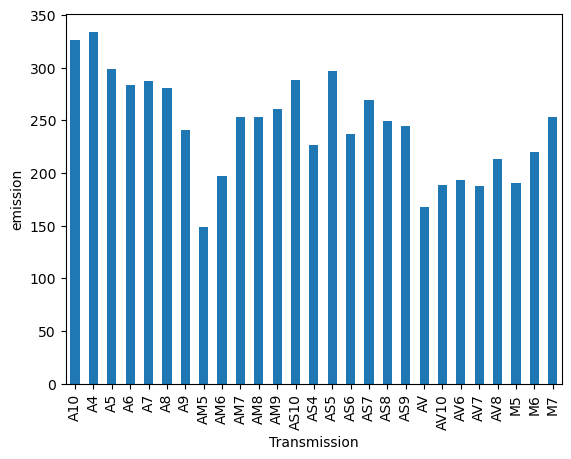

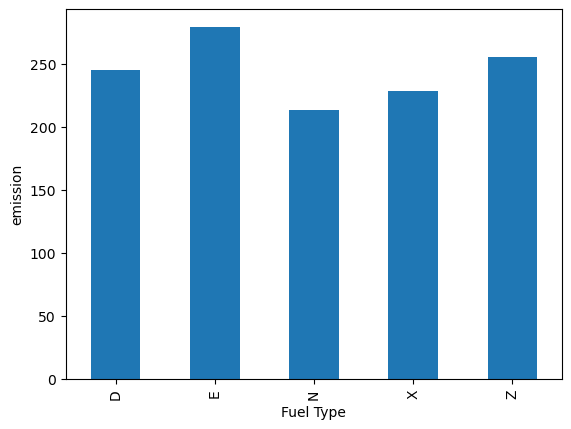

In [15]:
## relationship with target variable

for feature in cat_features:
    data = df.copy()
    
    data.groupby(feature)['CO2 Emissions(g/km)'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('emission')
    plt.show()

##### Observations:
1. Bugatti has the highest emission
2. Vans (Cargo and Passenger) have the highest emission
3. AM5 engines have relatively lowest emission
4. E > Z > D > X > N fuel type emission rate

# Feature Engineering

In [16]:
dataset = df.copy()
dataset.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


## Transformation of Continuous Values

In [17]:
for feature in continuous_features:
    dataset[feature] = np.log(dataset[feature])

## Handling rare Categorical Features

We cannot classify 'Make' or 'Transmission' as there are more categories in it and they have a relationship with Emission. There are not enough rare variables in the other categories that the need to declare them explicitly should arise

### Converting Categorical features to Numerical features

Since each categorical feature has a strong relationship with Emission we should use ordinal encoding

We will not convert 'Model' as we are dropping the feature later

In [18]:
for feature in cat_features:
    ordinal_labels = dataset.groupby(feature)['CO2 Emissions(g/km)'].max().sort_values().index
    ordinal_dict = {k:i for i, k in enumerate(ordinal_labels, 0)}
    dataset[feature] = data[feature].map(ordinal_dict)

In [19]:
dataset.drop(['Model'], axis = 1, inplace = True)
dataset.head()

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,4,9,0.693147,4,11,4,2.292535,1.902108,2.140066,3.496508,5.278115
1,4,9,0.875469,4,16,4,2.415914,2.041220,2.261763,3.367296,5.398163
2,4,9,0.405465,4,4,4,1.791759,1.757858,1.774952,3.871201,4.912655
3,4,3,1.252763,6,18,4,2.541602,2.208274,2.406945,3.218876,5.541264
4,4,3,1.252763,6,18,4,2.493205,2.163323,2.360854,3.295837,5.497168


In [20]:
dataset.to_csv('processed_data.csv', index = False)

# Feature Selection

In [21]:
df = pd.read_csv('processed_data.csv')
df.head()

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,4,9,0.693147,4,11,4,2.292535,1.902108,2.140066,3.496508,5.278115
1,4,9,0.875469,4,16,4,2.415914,2.041220,2.261763,3.367296,5.398163
2,4,9,0.405465,4,4,4,1.791759,1.757858,1.774952,3.871201,4.912655
3,4,3,1.252763,6,18,4,2.541602,2.208274,2.406945,3.218876,5.541264
4,4,3,1.252763,6,18,4,2.493205,2.163323,2.360854,3.295837,5.497168


In [22]:
X = df.drop('CO2 Emissions(g/km)', axis = 1)
y = df.iloc[:, -1]

## Dropping with correlation

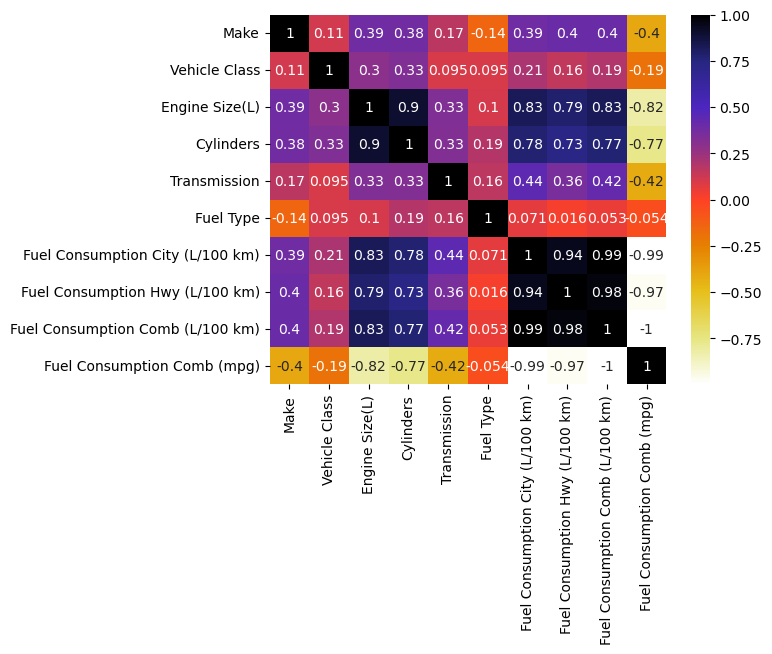

In [23]:
cor = X.corr()
sns.heatmap(cor, annot = True, cmap = plt.cm.CMRmap_r)
plt.show()

We can drop columns with correlation > 0.85

In [24]:
X = X.drop(['Cylinders', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)'], axis = 1)

In [43]:
X.head()

,Make,Vehicle Class,Engine Size(L),Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Comb (mpg)
0,4,9,0.693147,11,4,2.292535,3.496508
1,4,9,0.875469,16,4,2.415914,3.367296
2,4,9,0.405465,4,4,1.791759,3.871201
3,4,3,1.252763,18,4,2.541602,3.218876
4,4,3,1.252763,18,4,2.493205,3.295837


## Feature Scaling

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [26]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [27]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models

## Linear Regression

In [28]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)

LinearRegression()

In [29]:
linear_regressor.score(X_test_scaled, y_test)

0.9138368003133324

### Cross Validation

In [30]:
scores = cross_val_score(linear_regressor, X_train_scaled, y_train, cv=5)
print(np.mean(scores))

0.9210429957969073


## Ridge Regression

In [31]:
ridge_regressor = Ridge(alpha = 1)
ridge_regressor.fit(X_train_scaled, y_train)

Ridge(alpha=1)

In [32]:
ridge_regressor.score(X_test_scaled, y_test)

0.9135583253963251

## Lasso Regression

In [33]:
lasso_regr = Lasso(alpha = 0.005)
lasso_regr.fit(X_train_scaled, y_train)

Lasso(alpha=0.005)

In [34]:
lasso_regr.score(X_test_scaled, y_test)

0.8794814001041217

In [35]:
lasso_regr.coef_

array([ 0.        , -0.        ,  0.2642909 ,  0.        ,  0.        ,
        0.43125505, -0.61730127])

## Random Forest Regression

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [37]:
regressor = RandomForestRegressor()

regressor.fit(X_train, y_train)

RandomForestRegressor()

In [38]:
regressor.score(X_test, y_test)

0.9937356994970724